In [137]:
%matplotlib inline 
#display images generated in line

'''
#Description about MSM

Markov State Model (MSM) is a powerful method to investigate the conformational dynamics of proteins. 
MSM achieves the analysis by building a master equation from the Molecular Dynamics (MD) dataset.
Most of the kinetic and thermodynamic properties can be computed from the master equation

The general protocol of MSM includes: 
1.Clustering the conformational space into states. This is usually achieved by the splitting-and-lumping algorithm.
   1.0. We perform tICA to select kinetically slow subspace for the clustering stage
   1.1. We  split the conformational space into hundreds of microstates based on the geometric proximity.
        KMeans or kcenters is commonly used in the splitting stage.
   1.2. We then lump the microstates into macrostates based on the kinetic proximity, Spectral-based clustering is commonly applied.

2. Build the master equation (P(\tau)=T(\tau) P(0), T(\tau) is the transition probability matrix)
   2.0. Select a proper lag time so that the state-model will be Markovian (lose memory). The lag time is often chosen based on the implied timescale plot
   2.1. Calculate the transition probability matrix (TPM). TPM is the key to MSM.
   (We can build MSM on microstate model or macrostate model, as long as the model becomes Markovian)
3. Extract kinetic properties from the MSM, for example: Mean first passage time (MFPT) and transition pathways (obtained by transition path theory (TPT))

References:[1]Constructing Markov State Models to elucidate the functional conformational changes of complex biomolecules
           [2]MSMBuilder: Statistical Models for Biomolecular Dynamics
           [3]PyEMMA 2: A Software Package for Estimation, Validation, and Analysis of Markov Models.

This notebook contains the whole pipline to perform MSM analysis. Specifically, we run tICA, splitting-and-lumping, and TPT.

This script is written by Wei Wang (wwangat@gmail.com)

Dependency of this script: msmbuilder (>3.6.0 version), pyemma 2

'''

'\n#Description about MSM\n\nMarkov State Model (MSM) is a powerful method to investigate the conformational dynamics of proteins. \nMSM achieves the analysis by building a master equation from the Molecular Dynamics (MD) dataset.\nMost of the kinetic and thermodynamic properties can be computed from the master equation\n\nThe general protocol of MSM includes: \n1.Clustering the conformational space into states. This is usually achieved by the splitting-and-lumping algorithm.\n   1.0. We perform tICA to select kinetically slow subspace for the clustering stage\n   1.1. We  split the conformational space into hundreds of microstates based on the geometric proximity.\n        KMeans or kcenters is commonly used in the splitting stage.\n   1.2. We then lump the microstates into macrostates based on the kinetic proximity, Spectral-based clustering is commonly applied.\n\n2. Build the master equation (P(\tau)=T(\tau) P(0), T(\tau) is the transition probability matrix)\n   2.0. Select a prop

In [153]:
#load all the modules needed in the MSM analysis of the alanine dipeptide system
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import numpy as np

from msmbuilder.featurizer import AtomPairsFeaturizer, DihedralFeaturizer
from msmbuilder.cluster import KCenters
from msmbuilder.decomposition import tICA
from msmbuilder.dataset import dataset
from msmbuilder.msm import implied_timescales, MarkovStateModel
from msmbuilder.lumping import PCCAPlus
import pyemma.msm as pyemma_msm
from pyemma.plots import plot_free_energy
import msmtools.analysis

import matplotlib
#matplotlib.use('Agg')
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import mdtraj as md
from msmbuilder.io.sampling import sample_dimension
import random

In [154]:
#functions that will be used in the analysis

#featurizing_the_conformations: transform the xyz coordinates into features, the output will be used for tICA
def featurizing_the_conformations(featurizer, xtc_traj_folder, traj_list_array, pdb_name):
    #we usually use dihedral, rmsd or pairwise distance featurizers in MSM
    output_features=[]
    for trajfile in traj_list_array:
        xyz=dataset(trajectory_dir+trajfile, topology=trajectory_dir+pdb_name) #xyz is the coordinates for the frames in the trajectory
        temp=featurizer.fit_transform(xyz) #we transform the coordinates into pairwise distaneces
        print("loaded %s into (%d,%d) dimensional file"%(trajfile, len(temp[0]), len(temp[0][0])))
        output_features.append(temp[0])
    return output_features


##plots:
#draw_tica_projection: after tica, we draw the MD data projected onto major tICs
#plot_states_on_tic_space: the datapoints in same color belong to the same states
#plot_impliedtimescale: ITS shows how many basins

def draw_tica_histogram_core(x, y, tIC_a, tIC_b):
#    plt.axes(axisbg='w')
    plt.grid(False)
    plt.hist2d(x, y, bins=100, cmap='hot_r', norm=LogNorm())
    plt.xlabel('tIC %s'%(str(tIC_a)))
    plt.ylabel('tIC %s'%(str(tIC_b)))
    plt.title('tICA Heatmap (log color scale)')

def draw_tica_projection(resultdir, tica_trajs, opath, tIC_a, tIC_b):
    transformed=np.concatenate(tica_trajs)
    x = transformed[:, int(tIC_a)-1]
    y = transformed[:, int(tIC_b)-1]
    draw_tica_histogram_core(x, y,tIC_a, tIC_b)
    plt.colorbar()
    plt.savefig(resultdir + '/'+opath)
#    plt.close()
    
def plot_states_on_tic_space(resultdir, opath, tica_trajs, msm_traj, tIC_a, tIC_b):
    transformed_tic=np.concatenate(tica_trajs)
    transformed_assignments=np.concatenate(msm_traj)
    for j in range(min(transformed_assignments), max(transformed_assignments)+1):
        index = np.where(transformed_assignments == j)[0]
        plt.scatter(transformed_tic[index[::20], tIC_a-1], transformed_tic[index[::20], tIC_b-1],s=2)
    if(max(transformed_assignments)-min(transformed_assignments)<=6):
        plt.legend(['S'+str(i) for i in range(min(transformed_assignments), max(transformed_assignments)+1)])
    plt.xlabel('tIC %s'%(str(tIC_a)))
    plt.ylabel('tIC %s'%(str(tIC_b)))
    plt.title('tICA projections')
    plt.savefig(resultdir + '/'+opath)

def plot_Ramachandran(resultdir, opath, phi_psi, msm_traj):
    transformed_phi_psi=np.concatenate(phi_psi)
    transformed_assignments=np.concatenate(msm_traj)
    for j in range(min(transformed_assignments), max(transformed_assignments)+1):
        index = np.where(transformed_assignments == j)[0]
        plt.scatter(transformed_phi_psi[index[::20], 0]*180/np.pi, transformed_phi_psi[index[::20], 1]*180/np.pi,s=2)
    if(max(transformed_assignments)-min(transformed_assignments)<=6):
        plt.legend(['S'+str(i) for i in range(min(transformed_assignments), max(transformed_assignments)+1)])
    plt.xlabel('phi')
    plt.ylabel('psi')
    plt.xlim([-180, 180])
    plt.ylim([-180, 180])
    plt.title('Ramachandran plots')
    plt.savefig(resultdir + '/'+opath)
    
def plot_impliedtimescale(resultdir, opath, lag_times, msm_timescales, axis_unit):
    for i in range(len(msm_timescales[0])):
        plt.plot(lag_times, msm_timescales[:, i], 'o-')
    plt.title('Discrete-time MSM Relaxation Timescales')
    plt.xlabel(axis_unit)
    plt.ylabel(axis_unit)
    plt.semilogy()
    plt.savefig(resultdir + '/'+ opath)

##sampling the conformations

#sampling_along_tIC: intepret the physical meaning of tIC by sampling conforamtions along the dominant tICs
#sampling_along_msm_eigenmode: intepret the physical meaning of the slowest transition by sampling conformation along the msm eigenvectors

def sampling_along_tIC(resultdir, opath, tica_trajs, xtc_traj_folder, traj_list_array, pdb_name, tIC_a):
    transformed=np.concatenate(tica_trajs)
    draw_tica_histogram_core(transformed[:, 0], transformed[:, 1], '1', '2')
    tica_trajs = {i:tica_trajs[i] for i in range(len(tica_trajs))}    #tica_trajs is now a dictionary
    inds = sample_dimension(tica_trajs, dimension=tIC_a-1, n_frames=200, scheme='random') #sample 200 conformations
    #make trajectory
    traj = md.join(md.load_frame(xtc_traj_folder+traj_list_array[i], index=frame_i, top=xtc_traj_folder+pdb_name)
                  for i, frame_i in inds)
    #save the trajectory
    traj.save("%s/tica-dimension-tIC%s.xtc"%(resultdir, tIC_a-1))
    #show the samples on tICA projections
    samples_coord = []
    for i, frame_i in inds:
        samples_coord.append([tica_trajs[i][frame_i][0], tica_trajs[i][frame_i][1]])
    samples_coord = np.array(samples_coord)
    print(samples_coord.shape)
    plt.plot(samples_coord[:, 0], samples_coord[:, 1], 'o-')
    plt.legend('sample')
    plt.savefig(resultdir + '/' + opath)

def sampling_along_msm_eigenmode(resultdir, msm_eigen_trajs, assignment_list, xtc_traj_folder, traj_list_array, pdb_name, mode_num):
    #mode_num=1: the slowest dynamic mode (2nd eigenvector of TPM)
    info_list=[] #elements in info_list: [traj_id, frame_id, class_id, eigenvector_value]
    for j in range(len(assignment_list)):
        for k in range(len(assignment_list[j])):
            info_list.append([j, k, assignment_list[j][k], msm_eigen_trajs[j][k][mode_num-1]]) #index starts from 0
    #randomly sample 200 conformations
    samples=random.sample(info_list, 200) #can play with the number 200
    sorted_samples=sorted(samples, key=lambda x: x[3])
    #get the xtc file containing all the sampled conformations
    traj = md.join(md.load_frame(xtc_traj_folder+traj_list_array[i], index=frame_i, top=xtc_traj_folder+pdb_name)
                  for i, frame_i, class_id, eigenvector_value in sorted_samples)        
    traj.save("%s/msm-%s-dynamic-mode.xtc"%(resultdir, mode_num))

def sampling_representative_structures_for_MSM(resultdir, msm_traj, xtc_traj_folder, traj_list_array, pdb_name):
    transformed_assignments=np.concatenate(msm_traj)
    info_list=[] #elements in info_list: [traj_id, frame_id, class_id, eigenvector_value]
    for j in range(len(msm_traj)):
        for k in range(len(msm_traj[j])):
            info_list.append([j, k, msm_traj[j][k]])
    info_list = np.array(info_list)
    for j in range(min(transformed_assignments), max(transformed_assignments)+1):
        samples = random.sample(list(info_list[np.where(info_list[:, 2] == j)[0]]), 50)
        traj = md.join(md.load_frame(xtc_traj_folder+traj_list_array[i], index=frame_i, top=xtc_traj_folder+pdb_name)
                  for i, frame_i, class_id in samples)
        traj.save("%s/representative_structure_in_state%d.xtc"%(resultdir, j))

#run TPT to get the kinetic properties, based on the macrostate MSM, analytically
def evaluate_dominant_paths(TPM, lagtime, source_state, sink_state, time_unit):
    M = pyemma_msm.markov_model(TPM)
    tpt = pyemma_msm.tpt(M, [source_state], [sink_state])
    (paths,pathfluxes) = tpt.pathways()
    cumflux = 0
    print("Dominant pathways from state %d to state %d:"%(source_state, sink_state))
    print("path\t percentage")
    for i in range(len(paths)):
        print(paths[i], '\t','%3.1f'%(100.0*pathfluxes[i]/tpt.total_flux))
    print('MFPT from state %d to state %d  = %f %s'% (source_state, sink_state, M.mfpt(source_state, sink_state)*lagtime, time_unit))

    #Evaluate the MFPT and TPT based on the microstate model and the micro-to-macro mapping relationship, analytically
def calculate_macro_TPT_and_MFPT_basedon_micro_MSM(microTPM, mapping, source_state, sink_state, lagtime, time_unit):
    P = pyemma_msm.markov_model(microTPM) #TPM is row-normalized
    A = np.where(mapping==source_state)[0]
    B = np.where(mapping==sink_state)[0]
    print('MFPT from state %d to state %d = %f %s'%(source_state, sink_state, msmtools.analysis.mfpt(microTPM, A, B)*lagtime, time_unit))
    #get TPT

    tpt = pyemma_msm.tpt(P, A, B)
    (paths,pathfluxes) = tpt.pathways()
    cumflux = 0
    print("summarizing the pathways in macrostate form")
    temp_file=open('tpt_temp.log', 'w')
    for i in range(len(paths)):
        cumflux += pathfluxes[i]
        temp_file.write("%16.9f\t%16.9f\t%16.9f\t%s\n"%(pathfluxes[i], 100.0*pathfluxes[i]/tpt.total_flux, 100.0*cumflux/tpt.total_flux, mapping[paths[i]]))
    temp_file.close()
    os.system('bash lump.sh') #may do this in bash
    for line in open('tpt_pathlump.log'):
        print(line.strip())
    print('############################################################')
    print("more details about the paths in the microstate form")
    print("Path flux\t\t%path\t%of total\tpaths")
    for i in range(len(paths)):
        cumflux += pathfluxes[i]
        print(pathfluxes[i],'\t','%3.1f'%(100.0*pathfluxes[i]/tpt.total_flux),'%\t','%3.1f'%(100.0*cumflux/tpt.total_flux),'%\t',paths[i])

In [155]:
#specify the input files:
#1. folders to store the pdb file and the trajectories (in xtc or dcd format)
#2. the atom index or index pair for the pairwise distances used in tICA (index starts from 0 in python) 
#3. the name list for the trajectories

#In alanine dipeptide, the MD data is saved every 1 ps. Run at 300 K using Langevin

trajectory_dir='trajs/'  #folder to store the pdb and trajectories
pdb_name='ala2.pdb' #name for the topology file
trajname_list='trajname.list' #the name list for the trajectories in trajectory_dir
atom_pair_list='pairdist.list' #the pairwise distances list used in tICA
resultdir = './results'

In [156]:
if not os.path.exists(resultdir):
    os.makedirs(resultdir)
    
#load all the input files
print('now we are loading all the input files used in the tICA-MSM analysis')
atom_pairs = np.loadtxt(atom_pair_list, dtype=int) #import the pairwise distance index file as integer type
traj_list_array=[]
for line in open(trajname_list):
    traj_list_array.append(line.strip())

now we are loading all the input files used in the tICA-MSM analysis


loaded trajectory-0.dcd into (9999,45) dimensional file
loaded trajectory-1.dcd into (10000,45) dimensional file
loaded trajectory-2.dcd into (10000,45) dimensional file
loaded trajectory-3.dcd into (10000,45) dimensional file
loaded trajectory-4.dcd into (10000,45) dimensional file
loaded trajectory-5.dcd into (10000,45) dimensional file
loaded trajectory-6.dcd into (10000,45) dimensional file
loaded trajectory-7.dcd into (10000,45) dimensional file
loaded trajectory-8.dcd into (10000,45) dimensional file
loaded trajectory-9.dcd into (10000,45) dimensional file
now we have prepared the data for tICA: the pairwise distances for all frames in all trajectories
now we are sampling representative conformations along tIC1
(200, 2)
You can use vmd to visualize the tica-dimension-tIC1.xtc file


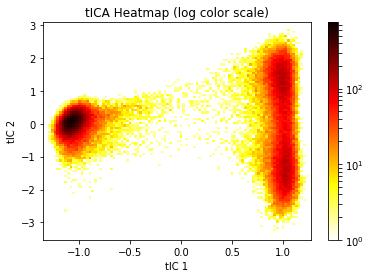

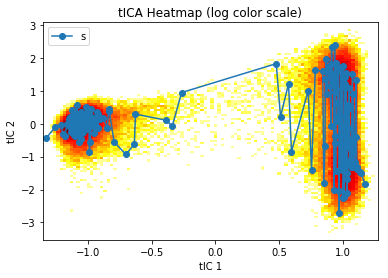

In [157]:
#step 1.0: tICA
#Select kinetic slow variables via tICA (time-lagged independent component analysis)
#tICA finds the linear combination of the input features that maximizing the normalized time-lagged correlation matrix
#In this example, we use pairwise distance of all heavy atoms as the input features for tICA.

#input: trajectories, output: tICA projections
#prepare data for tICA
featurizer = AtomPairsFeaturizer(pair_indices=atom_pairs) #In this example, we use pairwise distances
pairdist4tica = featurizing_the_conformations(featurizer, trajectory_dir, traj_list_array, pdb_name)
print("now we have prepared the data for tICA: the pairwise distances for all frames in all trajectories")

#run tICA
tica_model=tICA(lag_time=10,n_components=2) #tica lagged should be pre-specified, you can play with this number!
tica_trajs=tica_model.fit_transform(pairdist4tica)  #projected the MD data onto tica coordinates
#print("output of tica:", tica_trajs)
#plot the tica projections
draw_tica_projection(resultdir, tica_trajs,'tica_12.png', 1, 2)

#sample conformations along tIC1
print('now we are sampling representative conformations along tIC1')
plt.figure()
sampling_along_tIC(resultdir, 'samples_tic1.png', tica_trajs, trajectory_dir, traj_list_array, pdb_name, 1)
print("You can use vmd to visualize the tica-dimension-tIC1.xtc file")

output of msm: [array([37, 35, 37, ..., 30,  5, 68]), array([90,  4, 37, ..., 68, 25, 69]), array([90, 90, 54, ..., 35,  5, 57]), array([90, 19, 37, ..., 65, 27, 61]), array([90, 37, 75, ..., 54, 50, 29]), array([38, 37, 78, ..., 50, 69, 69]), array([38, 41, 37, ..., 41, 35, 37]), array([90, 90, 35, ..., 27, 65, 61]), array([90,  4, 37, ..., 50, 68, 68]), array([19, 38, 35, ..., 61, 27, 61])]


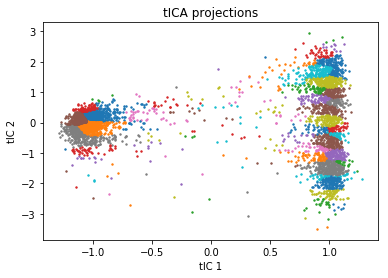

In [158]:
#step 1.1: split the conformations into hundreds of microstates
#perform kCenters on the tIC subspace
#input:tICA projections, output:assignments indicating which microstate each conformation is assigned to
nMicro=100 #specified a priori
kcenters=KCenters(n_clusters=nMicro, metric='euclidean', random_state=0)
microstate_sequences = kcenters.fit(tica_trajs)
print("output of msm:", microstate_sequences.labels_)

plt.figure()
plot_states_on_tic_space(resultdir, 'micorstate.png', tica_trajs, microstate_sequences.labels_, 1, 2)

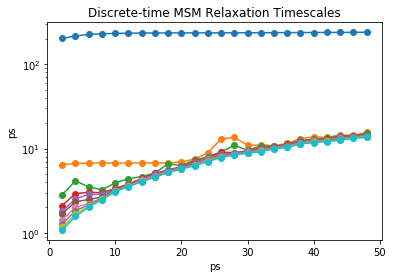

In [159]:
#plot the microstate implied timescale, which will show how many macrostates we need
plt.figure()
lag_times=range(2,50,2)
msm_timescales = implied_timescales(microstate_sequences.labels_, lag_times, n_timescales=10,msm=MarkovStateModel(reversible_type='transpose', ergodic_cutoff='off'))
plot_impliedtimescale(resultdir, 'microstate_its.png', lag_times, msm_timescales, 'ps')

In [160]:
####Evaluate the thermodynamics and kinetics from the microstate MSM
#the first dynamic eigenvector is associated to the slowest transitions in the dataset
#we can understand the physical meaning of the first eigenmode through sampling the conformations
micro_msm_lagtime=4
msm = MarkovStateModel(lag_time=micro_msm_lagtime, reversible_type='transpose', n_timescales=3, ergodic_cutoff='off') #lag time should be chosen such that the model becomes Markovian
#n_timescale specify the number of dynamic mode (the 1st one is the 2nd eigenvector of TPM) that outputs
msm.fit(microstate_sequences.labels_)
msm_eigen_trajs = msm.eigtransform(microstate_sequences.labels_)
sampling_along_msm_eigenmode(resultdir, msm_eigen_trajs, microstate_sequences.labels_, trajectory_dir, traj_list_array, pdb_name, 1) #1:the slowest transition,play with the eigenmodes
print("the timescale associated with the slowest collective motion in the system is: %d ps"%(msm.timescales_[0]))
print("using vmd to open msm-1-dynamic-mode.xtc, to intepret the slowest dynamic mode of the system")

the timescale associated with the slowest collective motion in the system is: 216 ps
using vmd to open msm-1-dynamic-mode.xtc, to intepret the slowest dynamic mode of the system


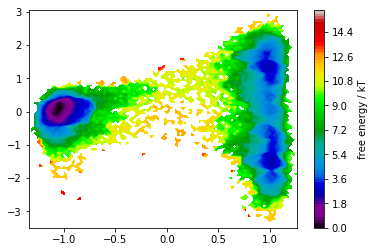

In [161]:
##Draw the potential of mean force, newly added
pi_0 = msm.populations_[np.concatenate(microstate_sequences.labels_, axis=0)] #microstate stationary population
xall = np.concatenate(tica_trajs)[:, 0]
yall = np.concatenate(tica_trajs)[:, 1]
plot_free_energy(xall, yall, weights=pi_0, logscale=True, nbins=100, cbar=True) #if specify "None", then not weighted by population
plt.savefig(resultdir+"/microstate_msm_PMF.png")

Optimization terminated successfully.
         Current function value: -2.456527
         Iterations: 12
         Function evaluations: 54
loaded trajectory-0.dcd into (9999,2) dimensional file
loaded trajectory-1.dcd into (10000,2) dimensional file
loaded trajectory-2.dcd into (10000,2) dimensional file
loaded trajectory-3.dcd into (10000,2) dimensional file
loaded trajectory-4.dcd into (10000,2) dimensional file
loaded trajectory-5.dcd into (10000,2) dimensional file
loaded trajectory-6.dcd into (10000,2) dimensional file
loaded trajectory-7.dcd into (10000,2) dimensional file
loaded trajectory-8.dcd into (10000,2) dimensional file
loaded trajectory-9.dcd into (10000,2) dimensional file


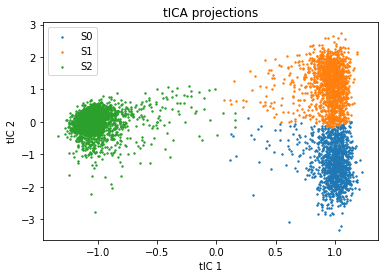

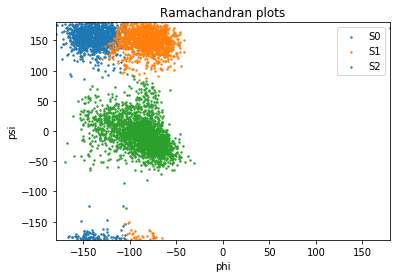

In [162]:
#judging from the above implied timescale, we need to lump the microstates into 3 macrostates
#lump kinetically close microstates into a few macrostates using PCCA+ algorithm, which will facilitate the visualization and intereptation of kinetics of the system
pcca = PCCAPlus.from_msm(msm, n_macrostates=3)
macro_trajs = pcca.transform(microstate_sequences.labels_)
#show the macrostates onto tICA space
plt.figure()
plot_states_on_tic_space(resultdir, 'macrostate.png', tica_trajs, macro_trajs, 1, 2)

#for alanine dipeptide, we can also validate the lumping using Ramanchandran plots
phi_psi_featurizer = DihedralFeaturizer(types=['phi', 'psi'], sincos=False) #if "True", then output sin, cos of the angles
phi_psi = featurizing_the_conformations(phi_psi_featurizer, trajectory_dir, traj_list_array, pdb_name)
plt.figure()
plot_Ramachandran(resultdir, 'macrostate_Ramachandran.png', phi_psi, macro_trajs)

In [163]:
##Evaluate the thermodynamics and kinetics of the system based on macrostate-MSM
#sample representative structures for each macrostate, used for visualization
sampling_representative_structures_for_MSM(resultdir, macro_trajs, trajectory_dir, traj_list_array, pdb_name)
print("you can now visualize the representative structures using vmd")

you can now visualize the representative structures using vmd


In [164]:
##For most of the cases, a Markovian macrostate model cannot be obtained, therefore we can evaluate the kinetics of the macrostate model
##based on the microstate MSM and the micro-to-macro mapping relationship
#newly added codes

source_state = 0
sink_state = 1
calculate_macro_TPT_and_MFPT_basedon_micro_MSM(msm.transmat_, pcca.microstate_mapping_, source_state, sink_state, micro_msm_lagtime, 'ps')

#here the msm.transmat_ is the microstate TPM

MFPT from state 0 to state 1 = 39.709567 ps
summarizing the pathways in macrostate form
tpt_temp.log
path-[01 ], pop:98.1484
path-[021 ], pop:1.85155
############################################################
more details about the paths in the microstate form
Path flux		%path	%of total	paths
0.0022909392851068805 	 3.5 %	 103.5 %	 [37 78]
0.0019808121329745075 	 3.0 %	 106.5 %	 [35 68]
0.0019157854720435268 	 2.9 %	 109.3 %	 [37 25]
0.0017807300993407196 	 2.7 %	 112.0 %	 [37 68]
0.001725707540091427 	 2.6 %	 114.6 %	 [35 78]
0.0015756460148660856 	 2.4 %	 117.0 %	 [35 25]
0.0015606398623435522 	 2.4 %	 119.4 %	 [ 4 78]
0.0015206234556167937 	 2.3 %	 121.7 %	 [35  5]
0.0014706029472083468 	 2.2 %	 123.9 %	 [37  5]
0.001225502456006956 	 1.9 %	 125.8 %	 [ 4 25]
0.001210496303484422 	 1.8 %	 127.6 %	 [ 4 68]
0.001195490150961888 	 1.8 %	 129.4 %	 [90 78]
0.0009503896597604965 	 1.4 %	 130.8 %	 [4 5]
0.0009403855580788072 	 1.4 %	 132.3 %	 [90 25]
0.0009003691513520489 	 1.4 %	 133.6 %

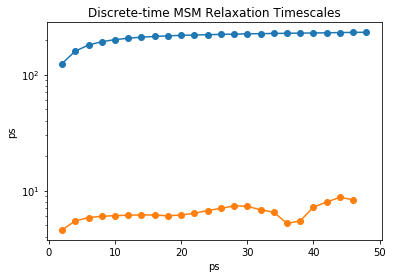

In [165]:
#plot the macrostate implied timescale, we can then select proper lag time to build the macrostate MSM
plt.figure()
lag_times=range(2,50,2)
msm_timescales = implied_timescales(macro_trajs, lag_times, n_timescales=3,msm=MarkovStateModel(reversible_type='transpose', ergodic_cutoff='off'))
plot_impliedtimescale(resultdir, 'macrostate_its.png', lag_times, msm_timescales, 'ps')

In [166]:
#Build the macrostate MSM and extract kinetics & thermodynamics based on the MSM
lag_time = 12 #the lag time where implied timescale reaches plateau 
msm = MarkovStateModel(lag_time, reversible_type='transpose', n_timescales=2) #lag time should be chosen such that the model becomes Markovian
#n_timescale specify the number of dynamic mode (the 1st one is the 2nd eigenvector of TPM) that outputs
msm.fit(macro_trajs)

#get the first dynamic eigenmode
print("the first dynamic eigenmode:", msm.right_eigenvectors_[:, 1])
print("the slowest transition happens between the macrostates with +ev & -ev eigenvector components")

#get the stationary population
print("Stationary population for the macrostates:", msm.populations_)

#get the transition pathways and mean first passage time from one state to another, using transition path theory (tpt)
source_state = 0
sink_state = 1
evaluate_dominant_paths(msm.transmat_, lag_time, source_state, sink_state, 'ps') #play with source state and sink state

MSM contains 1 strongly connected component above weight=0.08. Component 0 selected, with population 100.000000%
the first dynamic eigenmode: [-0.99264803 -0.95567528  1.02728736]
the slowest transition happens between the macrostates with +ev & -ev eigenvector components
Stationary population for the macrostates: [0.24432563 0.2691757  0.48649866]
Dominant pathways from state 0 to state 1:
path	 percentage
[0 1] 	 97.1
[0 2 1] 	 2.9
MFPT from state 0 to state 1  = 44.909369 ps


In [167]:
print("end of the example of alanine dipeptide")

end of the example of alanine dipeptide
